In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from tld import get_tld, is_tld

In [3]:
data = pd.read_csv('/home2/cslab/Videos/MlOps-Network-Security-Analysis/data/malicious_phish.csv')
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [5]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [6]:
count = data.type.value_counts()
count

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

Text(0, 0.5, 'Count')

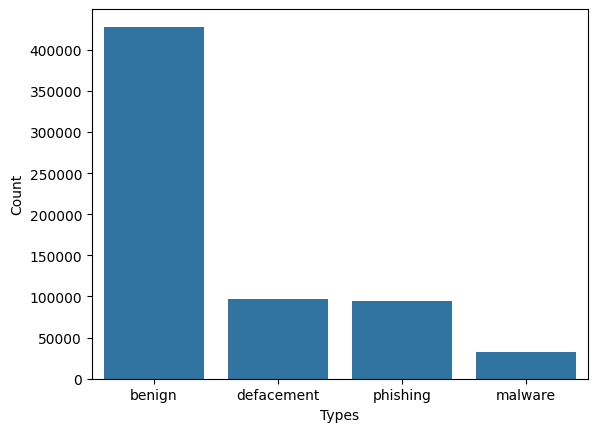

In [7]:
sns.barplot(x=count.index,y=count)
plt.xlabel('Types')
plt.ylabel('Count')

In [8]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [9]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [10]:
rem = {"Category": {"benign": 0, "defacement": 1, "phishing":2, "malware":3}}
data['Category'] = data['type']
data = data.replace(rem)

/tmp/ipykernel_9376/1624019599.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(rem)


In [11]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [12]:
def process_tld(url):
    try:
        res = get_tld(url,as_object=True,fail_silently=False,fix_protocol=True)
        pri_domain = res.parsed_url.netloc
    except:
        pri_domain = None
    return pri_domain        

In [13]:
print(process_tld("https://sub.example.com/page"))
# Output: sub.example.com

print(process_tld("example.com"))
# Output: example.com (fix_protocol=True adds 'http://' automatically)

print(process_tld("not_a_valid_url"))
# Output: None (invalid URL)


sub.example.com
example.com
None


In [14]:
data['domain'] = data['url'].apply(lambda i:process_tld(i))

In [15]:
data.head()

,url,type,Category,url_len,domain
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net


In [16]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [17]:
data.head()

,url,type,Category,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,br-icloud.com.br,phishing,2,16,br-icloud.com.br,0,0,1,0,2,0,0,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,mp3raid.com,0,0,0,0,2,0,0,0,0,0,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,bopsecrets.org,0,0,0,0,2,0,0,0,0,0,0,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,84,garage-pirenne.be,0,1,1,4,2,0,0,0,0,0,0,0,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,adventure-nicaragua.net,0,1,1,3,2,0,0,0,0,0,0,0,1


In [18]:
from urllib.parse import urlparse
import re

def abnormal_url(url):
    hostname = urlparse(url).hostname  # Extracts the hostname from the URL
    hostname = str(hostname)  # Ensures hostname is a string
    match = re.search(hostname, url)  # Checks if the hostname is present in the URL

    if match:
        return 1  # Hostname is present in the URL
    else:
        return 0  # Hostname is not found


In [19]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [20]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

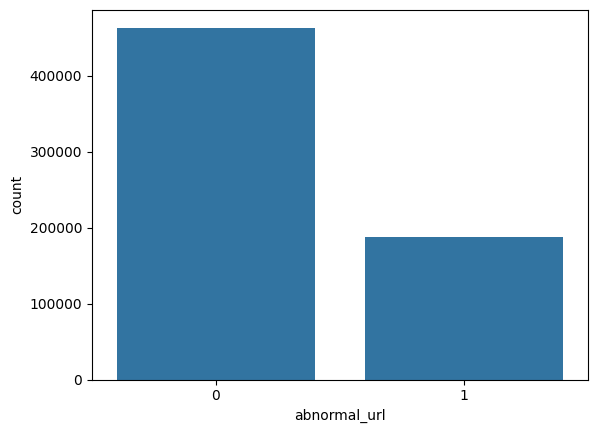

In [21]:
sns.countplot(x='abnormal_url', data=data);

In [22]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [23]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

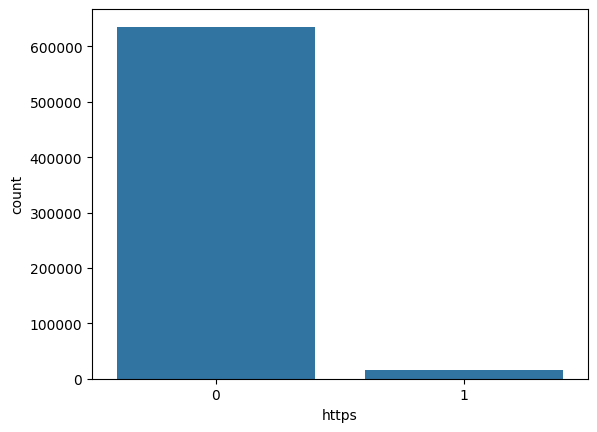

In [24]:

sns.countplot(x='https', data=data);

In [25]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [26]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

In [27]:
def letter_count(url):
    return sum(1 for i in url if i.isalpha())  # Efficient one-liner


In [28]:
print(letter_count("https://example.com/page"))  # Output: 17
print(letter_count("https://bit.ly/shortened123"))  # Output: 18
print(letter_count("https://abc-def.ghi.com"))  # Output: 12


19
19
17


In [29]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

In [30]:
import re

# Define a set of known URL shorteners for easy maintenance
SHORTENERS = {
    "bit.ly", "goo.gl", "shorte.st", "go2l.ink", "x.co", "ow.ly", "t.co",
    "tinyurl", "tr.im", "is.gd", "cli.gs", "yfrog.com", "migre.me", "ff.im",
    "tiny.cc", "url4.eu", "twit.ac", "su.pr", "twurl.nl", "snipurl.com",
    "short.to", "BudURL.com", "ping.fm", "post.ly", "Just.as", "bkite.com",
    "snipr.com", "fic.kr", "loopt.us", "doiop.com", "short.ie", "kl.am",
    "wp.me", "rubyurl.com", "om.ly", "to.ly", "bit.do", "lnkd.in", "db.tt",
    "qr.ae", "adf.ly", "bitly.com", "cur.lv", "tinyurl.com", "ity.im", "q.gs",
    "po.st", "bc.vc", "twitthis.com", "u.to", "j.mp", "buzurl.com", "cutt.us",
    "u.bb", "yourls.org", "prettylinkpro.com", "scrnch.me", "filoops.info",
    "vzturl.com", "qr.net", "1url.com", "tweez.me", "v.gd", "link.zip.net"
}


In [31]:
def is_shortened_url(url):
    return 1 if any(shortener in url for shortener in SHORTENERS) else 0

In [32]:
# Apply function to dataset
data['Shortining_Service'] = data['url'].apply(is_shortened_url)

<Axes: xlabel='Shortining_Service', ylabel='count'>

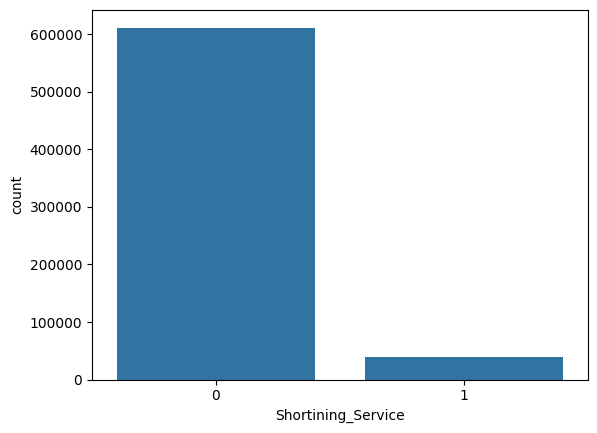

In [33]:
# Visualization
import seaborn as sns
sns.countplot(x='Shortining_Service', data=data)

In [34]:
import re
from urllib.parse import urlparse

# Regular expression to detect IP addresses in a URL
IP_REGEX = re.compile(
    r'(\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b)'  # Matches IPv4 addresses (e.g., 192.168.1.1)
    r'|(\b(?:[0-9A-Fa-f]{1,4}:){7}[0-9A-Fa-f]{1,4}\b)'  # Matches IPv6 addresses (e.g., 2001:db8::ff00:42:8329)
)

def has_ip_address(url):
    """Returns 1 if the URL contains an IP address, otherwise 0."""
    parsed_url = urlparse(url).netloc  # Extract the domain part
    return 1 if IP_REGEX.search(parsed_url) else 0

# ✅ **Example Usage**
print(has_ip_address("http://192.168.1.1/login"))  # ✅ 1 (Contains IPv4)
print(has_ip_address("https://[2001:db8::ff00:42:8329]/path"))  # ✅ 1 (Contains IPv6)
print(has_ip_address("https://example.com"))  # ❌ 0 (No IP)
print(has_ip_address("http://255.255.255.255:8080/admin"))  # ✅ 1 (IPv4 with port)


1
0
0
1


In [35]:
data['has_ip_address'] = data['url'].apply(lambda i: has_ip_address(i))

In [36]:
data['has_ip_address'].value_counts()

has_ip_address
0    639098
1     12093
Name: count, dtype: int64

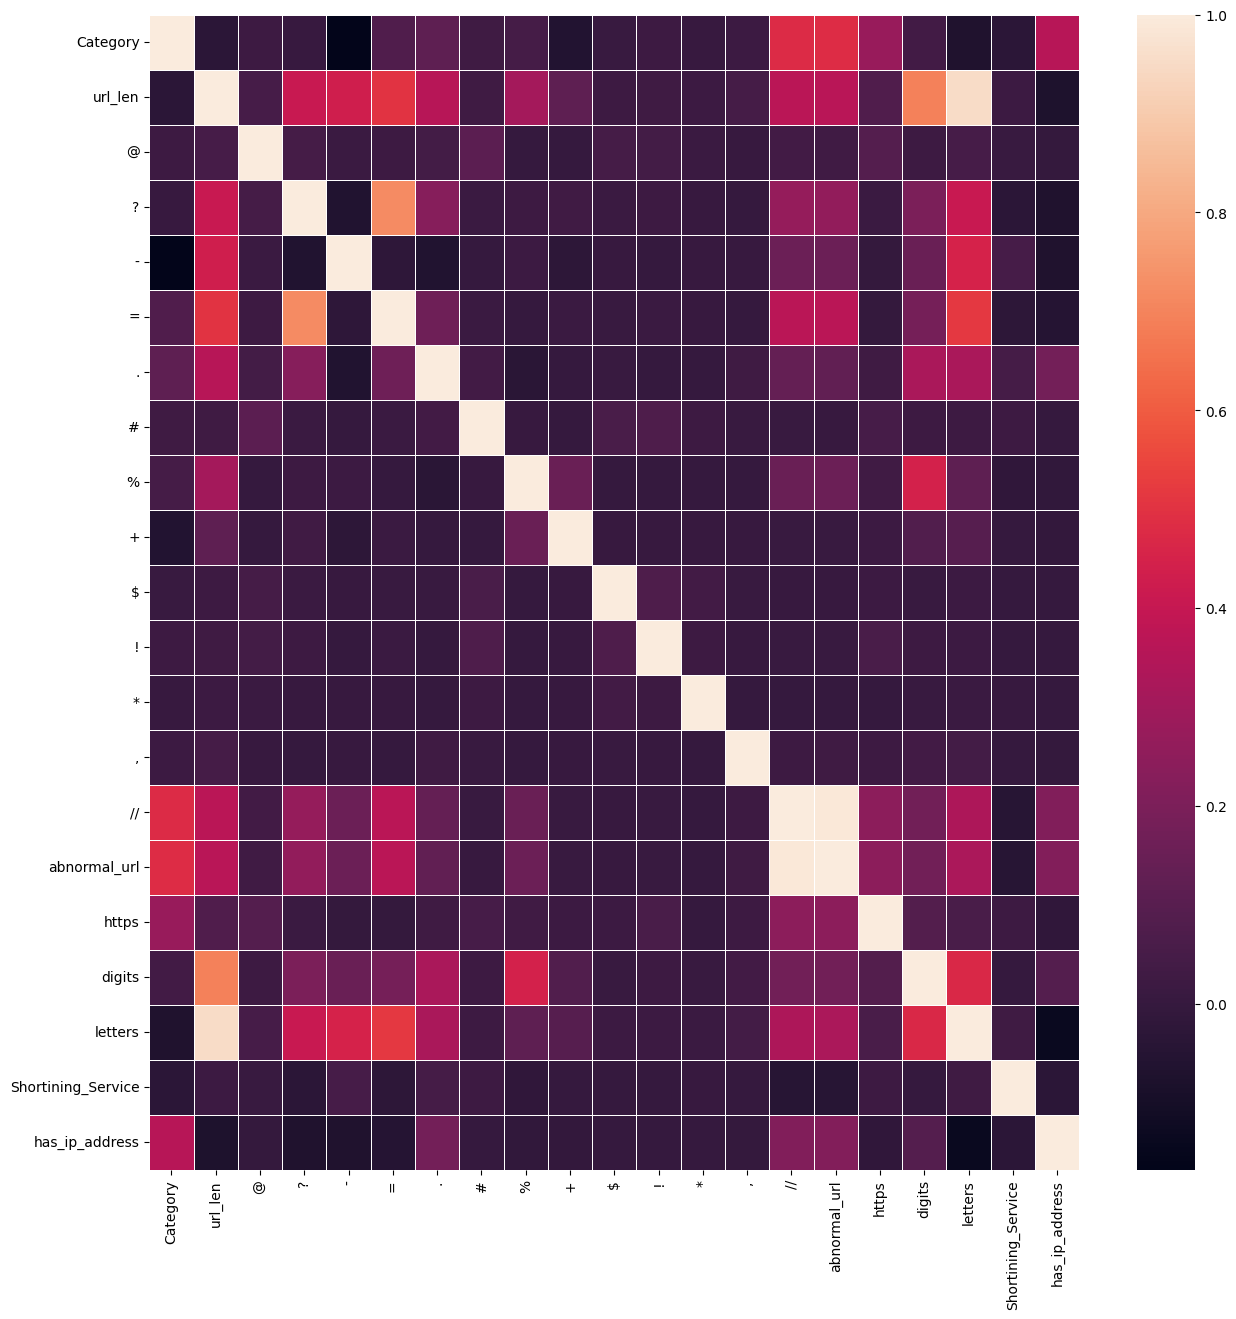

In [37]:
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr(numeric_only=True), linewidths=.5)
plt.show()


In [38]:
X = data.drop(['url','type','Category','domain'],axis=1)#,'type_code'
y = data['Category']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Training Models

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay


In [41]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.naive_bayes import GaussianNB

# models = [
#     DecisionTreeClassifier,
#     RandomForestClassifier,
#     AdaBoostClassifier,
#     KNeighborsClassifier,
#     SGDClassifier,
#     ExtraTreesClassifier,
#     GaussianNB
# ]

# accuracy_test = []

# for m in models:
#     print('#############################################')
#     print(f'######-Model =>\033[07m {m.__name__} \033[0m')

#     model_ = m()
#     model_.fit(X_train, y_train)
#     pred = model_.predict(X_test)
    
#     acc = accuracy_score(y_test, pred)  # Fix the order of parameters
#     accuracy_test.append(acc)

#     print(f'Test Accuracy :\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m')
    
#     print('\033[01m              Classification Report \033[0m')
#     print(classification_report(y_test, pred))
    
#     print('\033[01m              Confusion Matrix \033[0m')
#     cf_matrix = confusion_matrix(y_test, pred)

#     # Using ConfusionMatrixDisplay for better visualization
#     disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
#     disp.plot(cmap='Blues')
#     plt.title(f'Confusion Matrix for {m.__name__}')
#     plt.show()
    
#     print('\033[31m###################- End -###################\033[0m')


In [42]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier',
                                'AdaBoost Classifier','KNeighbors Classifier','SGD Classifier',
                                'Extra Trees Classifier','Gaussian NB'],
                      "Accuracy":accuracy_test})

ValueError: All arrays must be of the same length

In [ ]:
output

,Model,Accuracy
0,Decision Tree Classifier,0.909267
1,Random Forest Classifier,0.914734
2,AdaBoost Classifier,0.767888
3,KNeighbors Classifier,0.888843
4,SGD Classifier,0.798056
5,Extra Trees Classifier,0.914688
6,Gaussian NB,0.790132


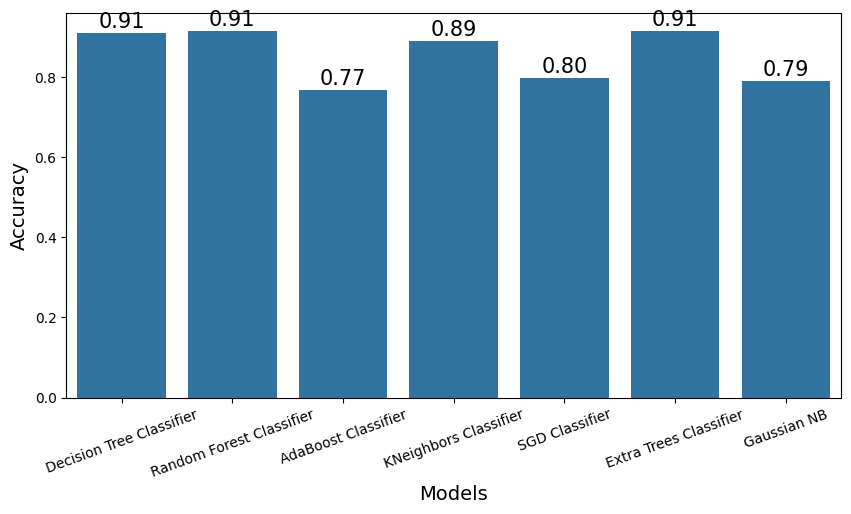

In [ ]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

#############################################
######-Model => DecisionTreeClassifier 
Best Parameters: {'criterion': 'entropy', 'max_depth': None}
Test Accuracy :  90.93%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     85565
           1       0.93      0.96      0.94     19319
           2       0.80      0.56      0.66     18805
           3       0.94      0.91      0.92      6550

    accuracy                           0.91    130239
   macro avg       0.90      0.85      0.87    130239
weighted avg       0.90      0.91      0.90    130239

              Confusion Matrix 


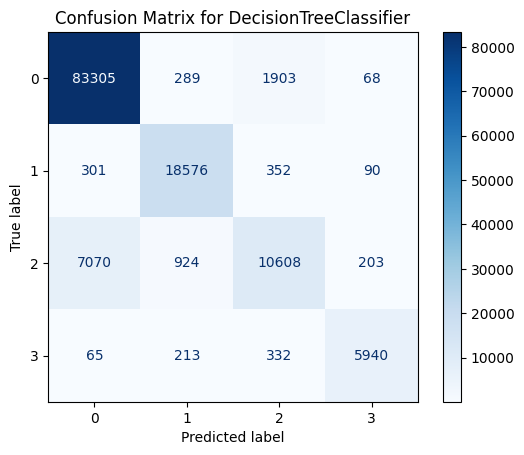

###################- End -###################
#############################################
######-Model => RandomForestClassifier 
Best Parameters: {'max_depth': None, 'n_estimators': 100}
Test Accuracy :  91.50%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     85565
           1       0.94      0.97      0.95     19319
           2       0.83      0.58      0.68     18805
           3       0.96      0.91      0.93      6550

    accuracy                           0.92    130239
   macro avg       0.91      0.86      0.88    130239
weighted avg       0.91      0.92      0.91    130239

              Confusion Matrix 


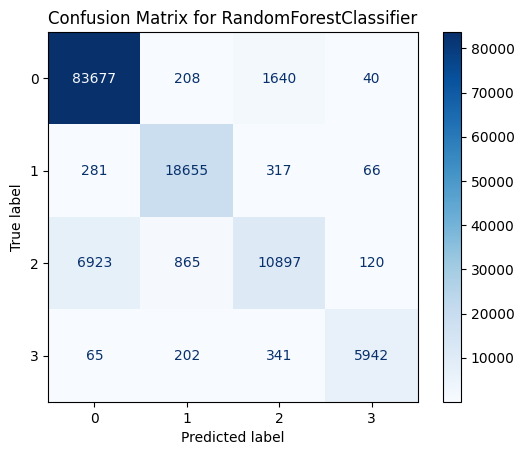

###################- End -###################
#############################################
######-Model => AdaBoostClassifier 
Best Parameters: {'learning_rate': 1.0, 'n_estimators': 200}
Test Accuracy :  80.36%  
              Classification Report 
              precision    recall  f1-score   support

           0       0.84      0.95      0.90     85565
           1       0.80      0.87      0.83     19319
           2       0.33      0.14      0.19     18805
           3       0.80      0.53      0.64      6550

    accuracy                           0.80    130239
   macro avg       0.69      0.62      0.64    130239
weighted avg       0.76      0.80      0.77    130239

              Confusion Matrix 


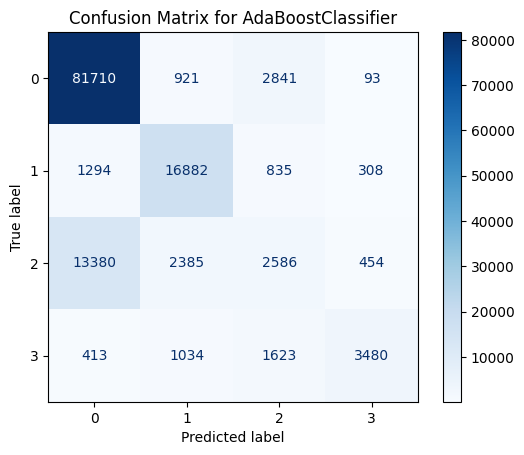

###################- End -###################
#############################################
######-Model => KNeighborsClassifier 


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

# 🔹 Define models and their hyperparameter grids
models_params = {
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {"max_depth": [3, 5, 10, None], "criterion": ["gini", "entropy"]}
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [10, 50, 100], "max_depth": [5, 10, None]}
    },
    "AdaBoostClassifier": {
        "model": AdaBoostClassifier(),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 1.0]}
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 10], "weights": ["uniform", "distance"]}
    },
    "SGDClassifier": {
        "model": SGDClassifier(),
        "params": {"alpha": [0.0001, 0.001, 0.01], "loss": ["hinge", "log_loss"]}
    },
    "ExtraTreesClassifier": {
        "model": ExtraTreesClassifier(),
        "params": {"n_estimators": [10, 50, 100], "max_depth": [5, 10, None]}
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {}  # No hyperparameters to tune for Naïve Bayes
    }
}

accuracy_test = []

for model_name, config in models_params.items():
    print('#############################################')
    print(f'######-Model =>\033[07m {model_name} \033[0m')

    model = config["model"]
    param_grid = config["params"]

    # 🔹 Use GridSearchCV if parameters exist, otherwise train normally
    if param_grid:
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f'Best Parameters: {grid_search.best_params_}')
    else:
        best_model = model.fit(X_train, y_train)

    pred = best_model.predict(X_test)
    
    acc = accuracy_score(y_test, pred)
    accuracy_test.append(acc)

    print(f'Test Accuracy :\033[32m \033[01m {acc*100:.2f}% \033[30m \033[0m')

    print('\033[01m              Classification Report \033[0m')
    print(classification_report(y_test, pred))

    print('\033[01m              Confusion Matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)

    # 🔹 Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    print('\033[31m###################- End -###################\033[0m')
